In [1]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !echo '{"username":"your_username","key":"your_api_key"}' > ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json


In [2]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces -p /content/dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.75G/3.75G [01:48<00:00, 37.3MB/s]
100% 3.75G/3.75G [01:48<00:00, 37.0MB/s]


In [3]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection -p /content/dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
License(s): CC-BY-NC-SA-4.0
 99% 429M/431M [00:11<00:00, 39.7MB/s]
100% 431M/431M [00:11<00:00, 38.8MB/s]


In [4]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

In [5]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )

    return model


In [6]:
base_path = '/content/dataset/real_vs_fake/real-vs-fake/train'
image_gen = ImageDataGenerator(rescale=1./255.,
                               rotation_range=20,
                               #shear_range=0.2,
                               #zoom_range=0.2,
                               horizontal_flip=True)

# Fix: Remove the extra 'train/' from the directory path
train_flow = image_gen.flow_from_directory(
    base_path,  # Use the base_path directly
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.


In [7]:
image_gen1 = ImageDataGenerator(rescale=1./255.)

# Update the path to the validation directory
valid_flow = image_gen1.flow_from_directory(
    '/content/dataset/real_vs_fake/real-vs-fake/valid', # Updated path for validation data
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1238s 392ms/step - accuracy: 0.6459 - loss: 0.6250 - val_accuracy: 0.7533 - val_loss: 0.5108
Epoch 2/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1179s 362ms/step - accuracy: 0.7607 - loss: 0.4971 - val_accuracy: 0.7893 - val_loss: 0.4504
Epoch 3/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1132s 362ms/step - accuracy: 0.8046 - loss: 0.4275 - val_accuracy: 0.8417 - val_loss: 0.3577
Epoch 4/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1144s 366ms/step - accuracy: 0.8314 - loss: 0.3782 - val_accuracy: 0.8584 - val_loss: 0.3277


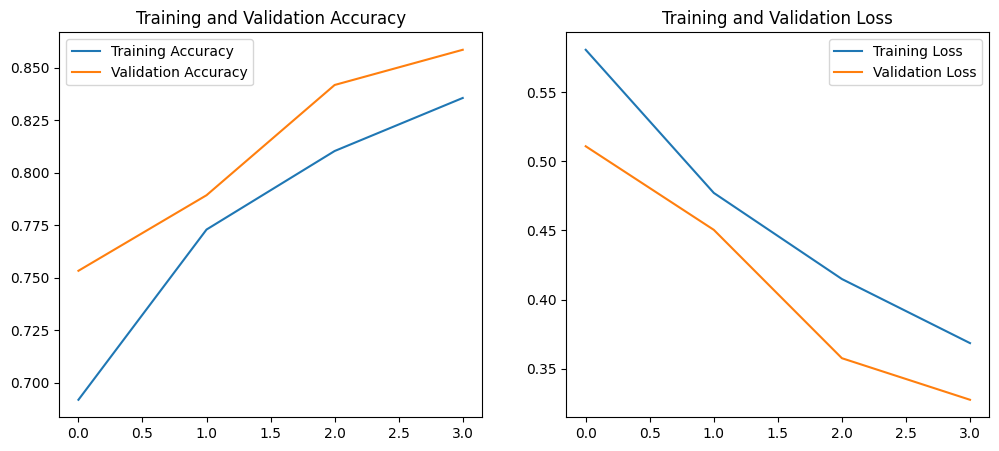

20000/20000 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step
ROC AUC Score: 0.9401447399999999
AP Score: 0.9377274422319617
              precision    recall  f1-score   support

           0       0.83      0.90      0.87     10000
           1       0.89      0.82      0.85     10000

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000



In [8]:
# Install required libraries
!pip install keras-vggface opencv-python tqdm

# Import necessary libraries
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
# Instead of: from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Use tensorflow.keras for ImageDataGenerator
from sklearn import metrics

# Dataset paths
base_path = '/content/dataset/real_vs_fake/real-vs-fake/'

# Data Generators
batch_size = 32  # Reduced batch size for CPU optimization
image_gen = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

image_gen1 = ImageDataGenerator(rescale=1./255.)
valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)
test_flow = image_gen1.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

# Model Definition
model = Sequential()
input_shape = (224, 224, 3)
activation = 'relu'
padding = 'same'
droprate = 0.1

model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(16, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(64, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(128, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(256, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the Model
train_steps = len(train_flow)
valid_steps = len(valid_flow)
history = model.fit(
    train_flow,
    epochs=4,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps
)

# Save the Model
model.save("custom_model_cpu_optimized.h5")

# Plot Training and Validation Loss/Accuracy
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

# Evaluate on Test Data
y_pred = model.predict(test_flow)
y_test = test_flow.classes

print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred > 0.5))


In [19]:
# %% [Grad-CAM Visualization - Updated]
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img

# Function to retrieve the name of the last Conv2D layer in the model
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

# Get the last conv layer name (we ignore retrieving the last dense layer since model.output is sufficient)
last_conv_layer_name = get_last_conv_layer(model)
print("Last convolutional layer:", last_conv_layer_name)

# Print model summary for reference
model.summary()

# Function to generate Grad-CAM heatmap using the last conv layer and model's output
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Force the model to build by doing a dummy prediction
    dummy_input = np.zeros((1, 224, 224, 3))
    model.predict(dummy_input)

    # Build a model that maps the input image to the activations of the last conv layer and the final predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    # Compute gradients with respect to the last conv layer
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by the corresponding pooled gradient
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Get one test image from the test generator using next()
img_batch, label_batch = next(test_flow)  # Use next() for DirectoryIterator
img = img_batch[0]  # Original image (rescaled)

# Prepare image for Grad-CAM (expand dims to create a batch of 1)
img_array = np.expand_dims(img, axis=0)

# Generate the Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Resize heatmap to match original image size
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert heatmap to 8-bit and apply a colormap
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
# Note: Original image is in [0,1]; convert it to [0,255] for visualization.
superimposed_img = cv2.addWeighted((img * 255).astype(np.uint8), 0.6, heatmap_color, 0.4, 0)

# Plot and display the original image and Grad-CAM overlay
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Overlay")
plt.axis("off")
plt.show()


Last convolutional layer: conv2d_9


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_6                │ (None, 224, 224, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 112, 112, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 56, 56, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 7, 7, 256)           │           1,0

 Total params: 1,182,589 (4.51 MB)

 Trainable params: 393,863 (1.50 MB)

 Non-trainable params: 998 (3.90 KB)

 Optimizer params: 787,728 (3.00 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


AttributeError: The layer sequential_1 has never been called and thus has no defined output.

In [9]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces -p /content/dataset --unzip


!kaggle datasets download -d ciplab/real-and-fake-face-detection -p /content/dataset --unzip


import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm


def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )

    return model



base_path = '/content/dataset/real_vs_fake/real-vs-fake/train'
image_gen = ImageDataGenerator(rescale=1./255.,
                               rotation_range=20,
                               #shear_range=0.2,
                               #zoom_range=0.2,
                               horizontal_flip=True)

# Fix: Remove the extra 'train/' from the directory path
train_flow = image_gen.flow_from_directory(
    base_path,  # Use the base_path directly
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)


image_gen1 = ImageDataGenerator(rescale=1./255.)

# Update the path to the validation directory
valid_flow = image_gen1.flow_from_directory(
    '/content/dataset/real_vs_fake/real-vs-fake/valid', # Updated path for validation data
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)








# Install required libraries
!pip install keras-vggface opencv-python tqdm --quiet

# Import necessary libraries
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from keras.optimizers import Adam

# Dataset paths
base_path = '/content/dataset/real_vs_fake/real-vs-fake/'

# Data Generators
batch_size = 32  # Reduced batch size for CPU optimization
image_gen = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

image_gen1 = ImageDataGenerator(rescale=1./255.)
valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)
test_flow = image_gen1.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

# Model Definition
model = Sequential()
input_shape = (224, 224, 3)
activation = 'relu'
padding = 'same'
droprate = 0.1

model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(16, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(64, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(128, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(256, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the Model
train_steps = len(train_flow)
valid_steps = len(valid_flow)
history = model.fit(
    train_flow,
    epochs=4,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps
)

# Save the Model
model.save("custom_model_cpu_optimized.h5")

# Plot Training and Validation Loss/Accuracy
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_metrics(history)

# Evaluate on Test Data
y_pred = model.predict(test_flow)
y_test = test_flow.classes

print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred > 0.5))

# -------------------- XAI: Grad-CAM --------------------

def get_gradcam_heatmap(model, image, last_conv_layer_index, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.layers[last_conv_layer_index].output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def overlay_heatmap_on_image(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output_image = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return output_image

# Select one test image from test_flow (batch_size=1)
test_batch = next(test_flow)
test_image = test_batch[0][0]  # Extract the first image from the batch

# For your model, the last Conv2D layer is at index 16.
last_conv_layer_index = 16
heatmap = get_gradcam_heatmap(model, test_image, last_conv_layer_index)

orig_image = np.uint8(test_image * 255)  # Convert from normalized [0,1] to [0,255]
overlay = overlay_heatmap_on_image(orig_image, heatmap, alpha=0.4)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(orig_image)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Overlay")
plt.axis("off")
plt.suptitle("Explainable AI (XAI) using Grad-CAM", fontsize=16)
plt.show()


Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.74G/3.75G [01:35<00:00, 42.6MB/s]
100% 3.75G/3.75G [01:35<00:00, 42.1MB/s]
Dataset URL: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
License(s): CC-BY-NC-SA-4.0
100% 431M/431M [00:11<00:00, 36.3MB/s]
100% 431M/431M [00:11<00:00, 37.8MB/s]
Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
 581/3125 ━━━━━━━━━━━━━━━━━━━━ 16:22 386ms/step - accuracy: 0.5858 - loss: 0.6764

KeyboardInterrupt: 

In [ ]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !echo '{"username":"your_username","key":"your_api_key"}' > ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Install required libraries
# !pip install tensorflow opencv-python tqdm scikit-learn matplotlib seaborn

# import tensorflow as tf
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# import matplotlib.pyplot as plt
# from sklearn import metrics
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # -------------------------------
# # 1. Data Preparation
# # -------------------------------
# base_path = '/content/dataset/real_vs_fake/real-vs-fake/'
# batch_size = 32
# target_size = (224, 224)

# # Aggressive data augmentation for training
# train_datagen = ImageDataGenerator(
#     rescale=1./255.,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2
# )
# # Simple rescaling for validation and test
# val_datagen = ImageDataGenerator(rescale=1./255.)
# test_datagen = ImageDataGenerator(rescale=1./255.)

# train_flow = train_datagen.flow_from_directory(
#     base_path + 'train/',
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode='binary'
# )
# val_flow = val_datagen.flow_from_directory(
#     base_path + 'valid/',
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode='binary'
# )
# test_flow = test_datagen.flow_from_directory(
#     base_path + 'test/',
#     target_size=target_size,
#     batch_size=1,
#     shuffle=False,
#     class_mode='binary'
# )

# # -------------------------------
# # 2. Build the Model using MobileNetV2 (Transfer Learning)
# # -------------------------------
# # Load the base model with pretrained ImageNet weights.
# base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
# base_model.trainable = False  # Freeze for initial training

# # Add a custom classification head.
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)  # Use high dropout to help generalization
# predictions = Dense(1, activation='sigmoid')(x)
# model = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model (initial phase)
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# # -------------------------------
# # 3. Callbacks & Training Settings
# # -------------------------------
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
#     ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
# ]

# # Limit steps per epoch to use only a subset of the full generator (reduce from ~3125 to 2000)
# steps_per_epoch = 2000
# validation_steps = min(50, len(val_flow))  # Adjust as needed

# # -------------------------------
# # 4. Phase 1: Feature Extraction (Frozen Base)
# # -------------------------------
# initial_epochs = 5
# history_initial = model.fit(
#     train_flow,
#     epochs=initial_epochs,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=val_flow,
#     validation_steps=validation_steps,
#     callbacks=callbacks,
#     verbose=1
# )

# # -------------------------------
# # 5. Phase 2: Fine-Tuning (Unfreeze Last Layers)
# # -------------------------------
# # Unfreeze the last 30 layers of the base model for fine-tuning.
# base_model.trainable = True
# for layer in base_model.layers[:-30]:
#     layer.trainable = False

# # Recompile with a lower learning rate for fine-tuning.
# model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# # Increase fine-tuning epochs so that total epochs = initial_epochs + fine_tune_epochs = 5 + 15 = 20
# fine_tune_epochs = 15
# total_epochs = initial_epochs + fine_tune_epochs
# history_fine = model.fit(
#     train_flow,
#     epochs=total_epochs,
#     initial_epoch=initial_epochs,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=val_flow,
#     validation_steps=validation_steps,
#     callbacks=callbacks,
#     verbose=1
# )

# model.save("mobilenetv2_finetuned.h5")

# # -------------------------------
# # 6. Plot Training Metrics
# # -------------------------------
# # Combine histories for plotting
# train_acc = history_initial.history['accuracy'] + history_fine.history['accuracy']
# val_acc = history_initial.history['val_accuracy'] + history_fine.history['val_accuracy']
# train_loss = history_initial.history['loss'] + history_fine.history['loss']
# val_loss = history_initial.history['val_loss'] + history_fine.history['val_loss']

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train_acc, label='Train Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(train_loss, label='Train Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

# # -------------------------------
# # 7. Evaluate on Test Data & Generate Confusion Matrix
# # -------------------------------
# y_pred = model.predict(test_flow)
# y_test = test_flow.classes
# roc_auc = metrics.roc_auc_score(y_test, y_pred)
# ap_score = metrics.average_precision_score(y_test, y_pred)

# print("ROC AUC Score:", roc_auc)
# print("Average Precision Score:", ap_score)
# print(metrics.classification_report(y_test, y_pred > 0.5))

# # Confusion Matrix
# y_pred_class = (y_pred > 0.5).astype("int32")
# cm = confusion_matrix(y_test, y_pred_class)
# print("Confusion Matrix:\n", cm)

# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()
